# Stochastic Weight Averaging (SWA)


[reference](https://blog.csdn.net/ChenVast/article/details/82142540)  
[Paper](https://arxiv.org/pdf/1803.05407.pdf)  
SWA隨機權重平均  
一個可以達到與Fast Geometric Ensembling([FGE](https://arxiv.org/pdf/1802.10026.pdf))集成學習相接近的學習成果  
縱然loss可能會比較差，但是其模型準確度卻能比較好  
其核心精神就是，一般的訓練其weight space上得到的結果通常是聚集在一個平坦空間的邊緣  
若將這些結果平均後，就能得到較好的weight
![](https://i.imgur.com/D2AX73f.png)


In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import glob
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.optimizers import adam
from keras.utils import Sequence

Using TensorFlow backend.
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Dog vs Cat dataset

利用貓狗數據，並利用VGG16 pre train model來當驗證  
首先train一組model  
* epoch=15  
* optimizer = adam(lr = 0.001)  

In [2]:
dataset = './dogs-vs-cats/VGG_Practice/'

train_folder = dataset + 'TRAIN'
val_folder = dataset + 'Validation'
test_folder = dataset + 'TEST'
os.listdir(train_folder)

['CAT', 'DOG']

In [4]:
# normalizing
Imagegen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_datagen = Imagegen.flow_from_directory(
            train_folder,
            target_size=(150,150),
            batch_size=batch_size,
            class_mode='binary'
            )

validation_datagen = Imagegen.flow_from_directory(
            val_folder,
            target_size=(150,150),
            batch_size=batch_size,
            class_mode='binary'
            )

test_datagen = Imagegen.flow_from_directory(
            test_folder,
            target_size=(150,150),
            batch_size=128,
            class_mode='binary',
            shuffle=False
            )

for train_batch, label_batch in train_datagen:
    print('train_batch_shape: ', train_batch.shape)
    print('label_batch_shape: ', label_batch.shape)
    break;

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
train_batch_shape:  (32, 150, 150, 3)
label_batch_shape:  (32,)


In [5]:
def call_vgg16_dog_vs_cat(input_shape=(150,150,3)):
    vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
    vgg_model.trainable = False
    model = Sequential()
    model.add(vgg_model)
    model.add(Flatten())
    model.add(Dense(100,activation = 'relu'))
    model.add(Dense(10,activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))
    return model

In [16]:
model = call_vgg16_dog_vs_cat()
optimizer = adam(lr=0.001)

model.summary()
model.compile(loss='binary_crossentropy',optimizer = optimizer, metrics = ['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               819300    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 15,535,009
Trainable params: 820,321
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
model_callback = [callbacks.ModelCheckpoint("./dogs-vs-cats/naive_best.model",
                                           monitor='val_acc',
                                           mode = 'max',
                                           save_best_only=True,
                                           verbose=1)]

In [18]:
train_history = model.fit_generator(train_datagen,
                                    steps_per_epoch=train_datagen.samples/batch_size,
                                    epochs=15,
                                    validation_data=validation_datagen,
                                    validation_steps=validation_datagen.samples/batch_size,
                                    callbacks=model_callback,
                                    verbose=1)

Epoch 1/15
125/125 [==============================] - 15s 124ms/step - loss: 0.3122 - acc: 0.8650 - val_loss: 0.2702 - val_acc: 0.8770

Epoch 00001: val_acc improved from -inf to 0.87700, saving model to ./dogs-vs-cats/naive_best.model
Epoch 2/15
125/125 [==============================] - 14s 115ms/step - loss: 0.2060 - acc: 0.9143 - val_loss: 0.2479 - val_acc: 0.8960

Epoch 00002: val_acc improved from 0.87700 to 0.89600, saving model to ./dogs-vs-cats/naive_best.model
Epoch 3/15
125/125 [==============================] - 15s 119ms/step - loss: 0.1551 - acc: 0.9357 - val_loss: 0.2480 - val_acc: 0.8920

Epoch 00003: val_acc did not improve from 0.89600
Epoch 4/15
125/125 [==============================] - 15s 123ms/step - loss: 0.1168 - acc: 0.9570 - val_loss: 0.2782 - val_acc: 0.8890

Epoch 00004: val_acc did not improve from 0.89600
Epoch 5/15
125/125 [==============================] - 15s 123ms/step - loss: 0.0828 - acc: 0.9700 - val_loss: 0.3037 - val_acc: 0.8880

Epoch 00005: val_

In [19]:
def plot_train_result(train_history):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_history.history['loss']), plt.plot(train_history.history['val_loss'])
    plt.legend(['train','validation'])
    plt.title('loss_history')
    plt.xlabel('Epoch'), plt.ylabel('loss',fontsize=20)
    
    plt.subplot(1,2,2)
    plt.plot(train_history.history['acc']), plt.plot(train_history.history['val_acc'])
    plt.legend(['train','validation'])
    plt.title('acc_history')
    plt.xlabel('Epoch'), plt.ylabel('Acc',fontsize=20)
    plt.show()

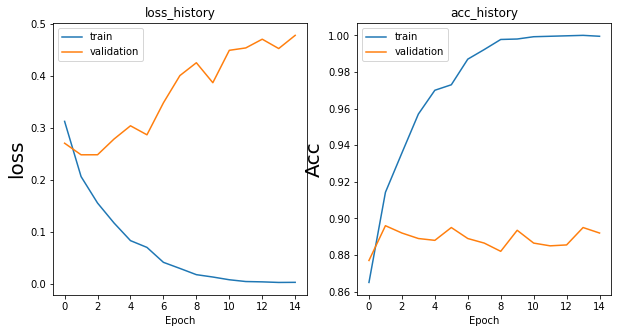

In [20]:
plot_train_result(train_history)

## Result1

accuracy達到88.45%

In [21]:
scores = model.evaluate_generator(test_datagen,steps=len(test_datagen))
print('test data accuracy: %.2f' %(scores[1]*100))

test data accuracy: 88.45


## Model2 -- using SWA

定義SWA在callback module 中  

### 定義SWA
繼承Callback，需要定義的是
* __init__: 繼承原始的init並自訂義
* on_train_begin: 在訓練開始時的操作
* on_train_end: 在訓練結束時的操作
* on_epoch_end: 在每個epoch結束時怎麼操作，在這裡定義swa的儲存  

In [12]:
class SWA(keras.callbacks.Callback):
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch-self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):  
        if epoch == (self.swa_epoch):
            self.swa_weights = self.model.get_weights()
        elif epoch > self.swa_epoch :    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch-self.swa_epoch) + self.model.get_weights()[i])/((epoch-self.swa_epoch)  + 1)  
        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save(self.filepath)
        print('Final stochastic averaged weights saved to file.')

## Snapshot scheduler

定義snapshot schedule  
除了Swa的weight save  
需要另外定義learning rate scheduler  
自訂義一組callback list包裝在SnapshotCallbackBuilder  
其中learning rate的定義為 _cosine_anneal_schedule

In [23]:
class SnapshotCallbackBuilder:
    def __init__(self,epoches, nb_snapshot,init_lr=0.001):
        self.T = epoches
        self.N = nb_snapshot
        self.lr = init_lr
        
    def getcallback(self):
        callback_list=[
            callbacks.ModelCheckpoint("./dogs-vs-cats/snapshot_best.model",monitor='val_acc',
                                      mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]
        return callback_list
        
    def _cosine_anneal_schedule(self,epoch):
        cos_inner = np.pi * (epoch % (self.T // self.N))/(self.T // self.N)
        cos_out = 0.5*(np.cos(cos_inner) + 1)
        return 0.5*self.lr + 0.5*self.lr*cos_out

## Illustrate cosine_anneal_schedule

total 15 epoch, 1 cycle only

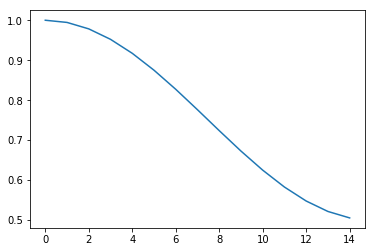

In [24]:
def check_cosine_anneal_schedule(epoch,T=15,N=1):
    cos_inner = (np.pi) * (epoch % (T // N))/(T // N)
    cos_out = 0.5*np.cos(cos_inner) + 0.5
    return 0.5* cos_out+0.5

x = np.arange(0,15)
plt.plot(x,check_cosine_anneal_schedule(x))

## Training

這裡SWA是利用最後三次的weight去做平均  
為了比較SWA結果，訓練途中另外紀錄了最佳的model weight去做比較  
總共15 epoch

In [28]:
epoch=15
snapshot_epoches=12

model2 = call_vgg16_dog_vs_cat()
model2.summary()
model2.compile(loss='binary_crossentropy',optimizer = optimizer, metrics = ['acc'])

swa = SWA('./dogs-vs-cats/swa_model.model',swa_epoch=snapshot_epoches)
SnapshotCallback = SnapshotCallbackBuilder(epoches=epoch,nb_snapshot=1)

train_history = model2.fit_generator(train_datagen,
                                    steps_per_epoch=train_datagen.samples/batch_size,
                                    epochs=epoch,
                                    validation_data=validation_datagen,
                                    validation_steps=validation_datagen.samples/batch_size,
                                    callbacks=SnapshotCallback.getcallback(),
                                    verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 15,535,009
Trainable params: 820,321
Non-trainable params: 14,714,688
_________________________________________________________________
Stochastic weight averaging selected for last 3 epochs.
Epoch 1/15
125/125 [==============================] - 16s 126ms/step

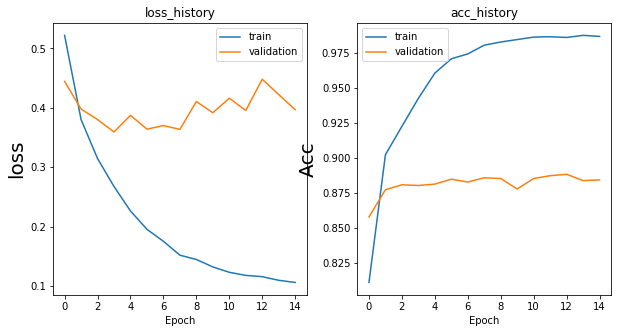

In [29]:
plot_train_result(train_history)

# Result

best model = 88.75  
swa = 89.20

In [30]:
from keras.models import load_model
model_eval = load_model('./dogs-vs-cats/snapshot_best.model')
scores = model_eval.evaluate_generator(test_datagen,steps=len(test_datagen))
print('test data accuracy on snap shot best model: %.2f' %(scores[1]*100))

model_eval = load_model('./dogs-vs-cats/swa_model.model')
scores = model_eval.evaluate_generator(test_datagen,steps=len(test_datagen))
print('test data accuracy on swa model: %.2f' %(scores[1]*100))

C:\Users\a2720\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


test data accuracy on snap shot best model: 88.75
test data accuracy on swa model: 89.20
